**Project Log**

1. 14th May: Just submitted a fmriprep job @ 1 node, 16 CPUs, 5GB. This takes job ID 26851918. Job was submitted around 3:20pm - we will note how long this process takes.
2. 16th May: Just submitted a fmriprep job @ 1 node, 16 CPUs, 6GB. This takes job ID 26939690. Job was submitted around 2pm - we will note how long this process takes. We have troubleshooted the freesurfer license and the memory problem for this run.
3. 17th May: Just submitted a fmriprep job @ 1 node, 16 CPUs, 6GB for subject #2 with job ID 26942808. Submitted at 3pm. We have used the fs-no-reconall option for this run.
4. 17th May: Just submitted a fmriprep job @ 1 node, 16 CPUs, 6GB for subject #3 with job ID 26951782 and fmriprep version 23.2.1. Submitted at 5:10pm. This also uses --fs-no-reconall and uses our own singularity build version.
5. 17th May: Just submitted a fmriprep job @ 1 node, 16 CPUs, 6GB for subject #3 with job ID 26953449 and fmriprep version 23.2.1. Submitted at 5:15pm. This also uses --fs-no-reconall and uses our own singularity build version.
6. 17th May: Just submitted a fmriprep job @ 1 node, 16 CPUs, 6GB for subject #3 with job ID 26953450 and fmriprep version 23.2.1. Submitted at 5:15pm. This also uses --fs-no-reconall and uses our own singularity build version. It also fixes freesurfer license. 
7. Meeting with Erica: She suggested looking into skull-stripping, the bids validation, disk space, and file permissions. 
8. Submitted 26975445 without ignore BIDS. 
9. 26975495
10. 26975497






In [1]:
import nibabel as nib
from nilearn import plotting

/gpfs/milgram/project/turk-browne/aa2842/conda_envs/myenv/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


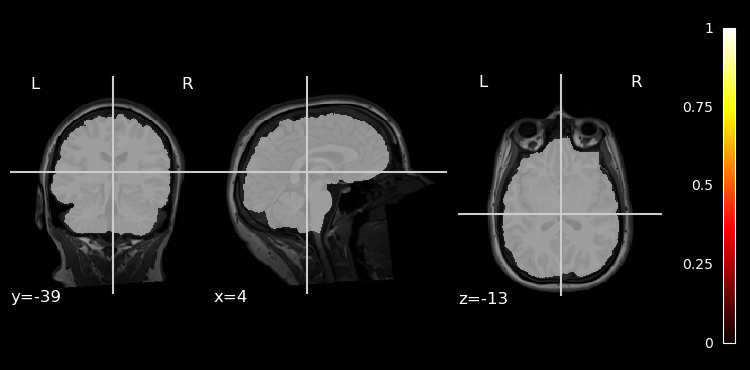

In [27]:
a = '/home/aa2842/scratch60/derivatives/sub-control01/anat/sub-control01_desc-brain_mask.nii.gz'
b = '/home/aa2842/scratch60/derivatives/sub-control01/anat/sub-control01_desc-preproc_T1w.nii.gz'

plotting.plot_stat_map(a, bg_img=b, alpha=0.5)

In [13]:
import numpy as np
c = '/home/aa2842/scratch60/derivatives/sub-control01/func/sub-control01_task-music_run-1_space-MNI152Lin_desc-preproc_bold.nii.gz'
d = nib.load(c)
e = d.get_fdata()
f = e.reshape((e.shape[0] * e.shape[1] * e.shape[2], e.shape[3]))


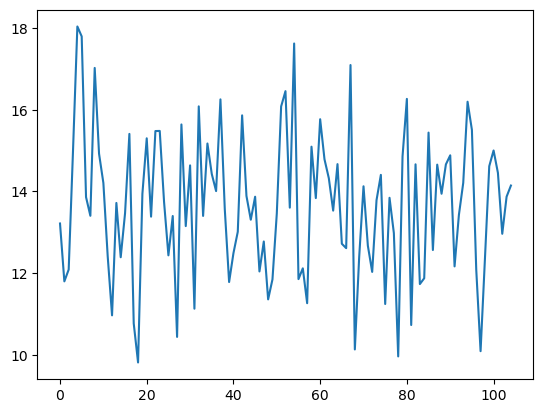

In [26]:
import matplotlib.pyplot as plt

plt.plot(f[0, :])

In [10]:
import pandas as pd

experiments = pd.read_csv('/gpfs/milgram/data/nsd/nsddata_timeseries/ppdata/subj01/func1mm/design/design_session01_run01.tsv')

In [19]:
import numpy as np
experiments.head(50)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [11]:
experiments

,0
0,0
1,0
2,0
3,0
4,0
...,...
294,0
295,0
296,0
297,0


In [20]:
from nilearn.datasets import fetch_spm_multimodal_fmri

subject_data = fetch_spm_multimodal_fmri()


Dataset created in /home/aa2842/nilearn_data/spm_multimodal_fmri

Missing 390 functional scans for session 1.
Data absent, downloading...


Downloaded 126648320 of 134263085 bytes (94.3%,    1.2s remaining) ...done. (21 seconds, 0 min)
Extracting data from /home/aa2842/nilearn_data/spm_multimodal_fmri/sub001/multimodal_fmri.zip..... done.


Downloaded 4276224 of 6852766 bytes (62.4%,    0.6s remaining) ...done. (2 seconds, 0 min)
Extracting data from /home/aa2842/nilearn_data/spm_multimodal_fmri/sub001/multimodal_smri.zip..... done.


In [23]:
# repetition time, in seconds
tr = 2.0
# Sample at the beginning of each acquisition.
slice_time_ref = 0.0
# We use a discrete cosine transform to model signal drifts.
drift_model = "Cosine"
# The cutoff for the drift model is 0.01 Hz.
high_pass = 0.01
# The hemodynamic response function
hrf_model = "spm + derivative"

In [24]:
import warnings

from nilearn.image import concat_imgs, mean_img, resample_img

# Avoid getting too many warnings due to resampling
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fmri_img = [
        concat_imgs(subject_data.func1, auto_resample=True),
        concat_imgs(subject_data.func2, auto_resample=True),
    ]
affine, shape = fmri_img[0].affine, fmri_img[0].shape
print("Resampling the second image (this takes time)...")
fmri_img[1] = resample_img(fmri_img[1], affine, shape[:3])

Resampling the second image (this takes time)...


In [28]:
mean_image = mean_img(fmri_img)

In [33]:
fmri_img[1].shape

(64, 64, 32, 390)

In [34]:
from nilearn.glm.first_level import make_first_level_design_matrix

design_matrices = []

In [35]:
fmri_img[0].shape[-1]

390

In [36]:
for idx, img in enumerate(fmri_img, start=1):
    # Build experimental paradigm
    n_scans = img.shape[-1]
    events = pd.read_table(subject_data[f"events{idx}"])
    # Define the sampling times for the design matrix
    frame_times = np.arange(n_scans) * tr
    # Build design matrix with the reviously defined parameters
    design_matrix = make_first_level_design_matrix(
        frame_times,
        events,
        hrf_model=hrf_model,
        drift_model=drift_model,
        high_pass=high_pass,
    )

    # put the design matrices in a list
    design_matrices.append(design_matrix)

In [42]:
design_matrices[0]

,faces,faces_derivative,scrambled,scrambled_derivative,drift_1,drift_2,drift_3,drift_4,drift_5,drift_6,drift_7,drift_8,drift_9,drift_10,drift_11,drift_12,drift_13,drift_14,drift_15,constant
0.0,0.000000,0.000000,0.000000,0.000000,0.071611,0.071609,0.071606,0.071602,0.071597,0.071591,0.071583,0.071574,0.071564,0.071553,0.071541,0.071528,0.071513,0.071498,0.071481,1.0
2.0,0.000000,0.000000,0.000000,0.000000,0.071606,0.071591,0.071564,0.071528,0.071481,0.071423,0.071355,0.071277,0.071188,0.071089,0.070980,0.070860,0.070730,0.070589,0.070438,1.0
4.0,0.000000,0.000000,0.000002,0.000017,0.071597,0.071553,0.071481,0.071379,0.071249,0.071089,0.070901,0.070684,0.070438,0.070164,0.069862,0.069531,0.069171,0.068784,0.068369,1.0
6.0,0.000000,0.000000,0.035696,0.053995,0.071583,0.071498,0.071355,0.071157,0.070901,0.070589,0.070221,0.069798,0.069318,0.068784,0.068195,0.067552,0.066855,0.066105,0.065303,1.0
8.0,0.000000,0.000000,0.178153,0.054774,0.071564,0.071423,0.071188,0.070860,0.070438,0.069924,0.069318,0.068621,0.067834,0.066958,0.065994,0.064943,0.063806,0.062586,0.061284,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770.0,0.181459,0.031979,0.106997,-0.047089,-0.071564,0.071423,-0.071188,0.070860,-0.070438,0.069924,-0.069318,0.068621,-0.067834,0.066958,-0.065994,0.064943,-0.063806,0.062586,-0.061284,1.0
772.0,0.164961,-0.034390,0.028966,-0.029912,-0.071583,0.071498,-0.071355,0.071157,-0.070901,0.070589,-0.070221,0.069798,-0.069318,0.068784,-0.068195,0.067552,-0.066855,0.066105,-0.065303,1.0
774.0,0.151480,0.034003,-0.011395,-0.012698,-0.071597,0.071553,-0.071481,0.071379,-0.071249,0.071089,-0.070901,0.070684,-0.070438,0.070164,-0.069862,0.069531,-0.069171,0.068784,-0.068369,1.0
776.0,0.223142,0.010724,-0.014054,0.023511,-0.071606,0.071591,-0.071564,0.071528,-0.071481,0.071423,-0.071355,0.071277,-0.071188,0.071089,-0.070980,0.070860,-0.070730,0.070589,-0.070438,1.0
